In [12]:
%%bash
# preamble script to check and install AMUSE components if necessary

# required packages for this tutorial:
PACKAGES="amuse-framework amuse-kepler"
# skip in case a full development install is present
pip show amuse-devel && exit 0
for package in ${PACKAGES} 
do
  pip show ${package} || pip install ${package}
done


Name: amuse-devel
Version: 2024.6.1.dev9+gecb3db99e
Summary: The Astrophysical Multipurpose Software Environment
Home-page: http://www.amusecode.org/
Author: The AMUSE team
Author-email: info@amusecode.org
License: Apache License 2.0
Location: /home/ybadoux/miniforge3/envs/Amuse-env/lib/python3.12/site-packages
Editable project location: /home/ybadoux/amuse-src
Requires: docutils, h5py, numpy, pip, pytest, setuptools, setuptools-scm, wheel
Required-by: 


In [13]:
# the following fixes are highly recommended

#allow oversubscription for openMPI
import os
os.environ["OMPI_MCA_rmaps_base_oversubscribe"]="true"

# use lower cpu resources for idle codes
from amuse.support import options
options.GlobalOptions.instance().override_value_for_option("polling_interval_in_milliseconds", 10)


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from amuse.units import units, constants
from amuse.lab import Particles, Particle
from amuse.ext.orbital_elements import generate_binaries, orbital_elements

from amuse.community.huayno.interface import Huayno
from amuse.units import nbody_system
from amuse.ext.LagrangianRadii import LagrangianRadii

import matplotlib.pyplot as plt
from tqdm import tqdm

# We define some properties for the figures
import matplotlib as mpl
SMALL_SIZE = 10 * 2 
MEDIUM_SIZE = 12 * 2
BIGGER_SIZE = 14 * 2

# plt.rc('text', usetex=True)
plt.rc('axes', titlesize=SMALL_SIZE)                     # fontsize of the axes title\n",
plt.rc('axes', labelsize=MEDIUM_SIZE)                    # fontsize of the x and y labels\n",
plt.rc('xtick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('ytick', labelsize=SMALL_SIZE, direction='out')   # fontsize of the tick labels\n",
plt.rc('legend', fontsize=SMALL_SIZE)                    # legend fontsize\n",
mpl.rcParams['axes.titlesize'] = BIGGER_SIZE
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['font.family'] = 'STIXgeneral'

mpl.rcParams['figure.dpi'] = 100

mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['ytick.minor.size'] = 4

mpl.rcParams['xtick.major.width'] = 1.25
mpl.rcParams['ytick.major.width'] = 1.25
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1

In [15]:
SMBH_ORBITAL_RADIUS = 44 * 1e-3 | units.parsec
SMBH_ECCENTRICITY = 0.32

PRIMARY_MASS = 2.8 | units.MSun
SECONDARY_MASS = 0.73 | units.MSun

BINARY_SEPARATION = 1.59 | units.AU
BINARY_INCLINATION = 102.55 | units.deg
BINARY_ECCENTRICITY = 0.45
BINARY_PERIAPSE = 311.75 | units.deg


SMBH_MASS = 4.297e6 | units.MSun


def orbital_period(mass, radius):
    return np.sqrt(radius.value_in(units.AU)**3 / mass.value_in(units.MSun)) | units.yr


smbh_binary_period = orbital_period(SMBH_MASS, SMBH_ORBITAL_RADIUS)
binary_period = orbital_period(PRIMARY_MASS + SECONDARY_MASS, BINARY_SEPARATION)
kozai_timescale = smbh_binary_period**2 / binary_period
print(smbh_binary_period, binary_period)
print(kozai_timescale.value_in(units.yr))


417.094091419 yr 1.06710789682 yr
163027.076845


[[-0.000560622350111, -4.77185464982e-05, 0.000214359021889]] kms
                 key         mass         name           vx           vy           vz            x            y            z
                   -         MSun         none  8028481.01748 * m * s**-1  8028481.01748 * m * s**-1  8028481.01748 * m * s**-1  3.08567758128e+16 * m  3.08567758128e+16 * m  3.08567758128e+16 * m
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 2207286918880862869    4.297e+06         SMBH   -5.736e-14   -4.883e-15    2.193e-14    1.844e-15   -5.649e-15    2.538e-14
18158352511218013270    2.800e+00      primary   -1.385e-03   -1.236e-03   -2.670e-08   -5.861e-07    6.610e-07   -3.089e-08
 6952509942198008656    7.300e-01    secondary    5.312e-03    4.741e-03   -2.670e-08    2.237e-06   -2.502e-06   -3.089e-08
====================  ===========  ===========  ===========  ===========  ===========  ===========  =========== 

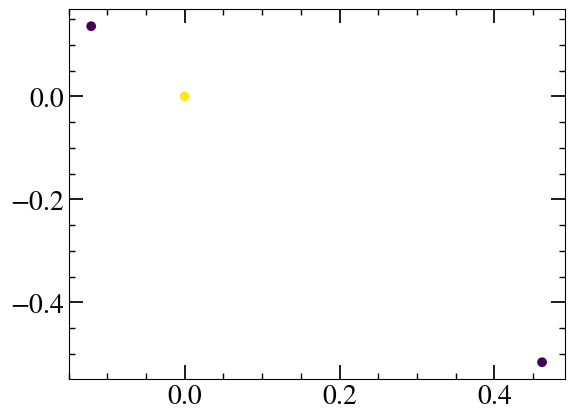

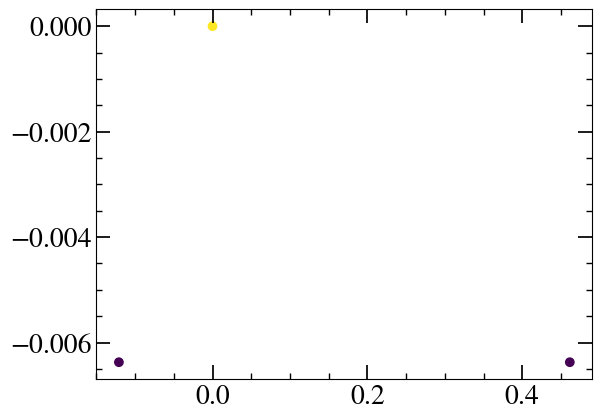

In [30]:
binary, smbh = generate_binaries(PRIMARY_MASS+SECONDARY_MASS,
                                 SMBH_MASS,
                                 SMBH_ORBITAL_RADIUS,
                                 eccentricity = SMBH_ECCENTRICITY,
                                 true_anomaly =  1.5 | units.rad,
                                 inclination = BINARY_INCLINATION)

smbh.name = 'SMBH'
print(smbh.velocity.in_(units.kms))

primary, secondary = generate_binaries(PRIMARY_MASS, 
                                        SECONDARY_MASS, 
                                        BINARY_SEPARATION, 
                                        eccentricity=BINARY_ECCENTRICITY, 
                                        true_anomaly=0 | units.rad, # fixed value for reproducibility
                                        inclination = 0 | units.rad,
                                        argument_of_periapsis=BINARY_PERIAPSE)
binary_com_velocity = (constants.G * smbh.mass / SMBH_ORBITAL_RADIUS).sqrt()

primary.name = 'primary'
secondary.name = 'secondary'

smbh_and_binary = Particles(0)

smbh_and_binary.add_particle(smbh)
smbh_and_binary.add_particle(primary)
smbh_and_binary.add_particle(secondary)

smbh_and_binary.move_to_center()

print(smbh_and_binary)

plt.scatter(smbh_and_binary.x.value_in(units.AU), smbh_and_binary.y.value_in(units.AU), c = smbh_and_binary.mass.value_in(units.Msun))
plt.show()

plt.scatter(smbh_and_binary.x.value_in(units.AU), smbh_and_binary.z.value_in(units.AU), c = smbh_and_binary.mass.value_in(units.Msun))
plt.show()


In [17]:
from amuse.ext.protodisk import ProtoPlanetaryDisk

R = 1 | units.AU

converter = nbody_system.nbody_to_si(smbh_and_binary.mass.sum(), SMBH_ORBITAL_RADIUS)

# Rmax = 11 | units.AU
# Rmin = 4*(1+BINARY_ECCENTRICITY)*BINARY_SEPARATION
Rmax = 12 | units.AU
Rmin = 8 | units.AU
disk_width = Rmax-Rmin
Mdisk = 1.6e-6 | units.MSun
Mstar = PRIMARY_MASS + SECONDARY_MASS + Mdisk
Ndisk = 1000

print(Rmax, Rmin.in_(units.AU), disk_width.in_(units.AU))

converter_disk = nbody_system.nbody_to_si(PRIMARY_MASS+SECONDARY_MASS+Mdisk, R)

# create hydro disk
disk = ProtoPlanetaryDisk(Ndisk, convert_nbody=converter_disk, Rmin=Rmin/R, Rmax=Rmax/R, discfraction=Mdisk/Mstar).result
disk.name = 'disk'

# move particles to correct position
com_binary = (smbh_and_binary[1].position*PRIMARY_MASS + smbh_and_binary[2].position*SECONDARY_MASS)/(PRIMARY_MASS+SECONDARY_MASS)
disk.position += com_binary
disk.velocity += (0,1,0)*binary_com_velocity

#TODO: rorate disk to correct orientation

12 au 8 au 4 au


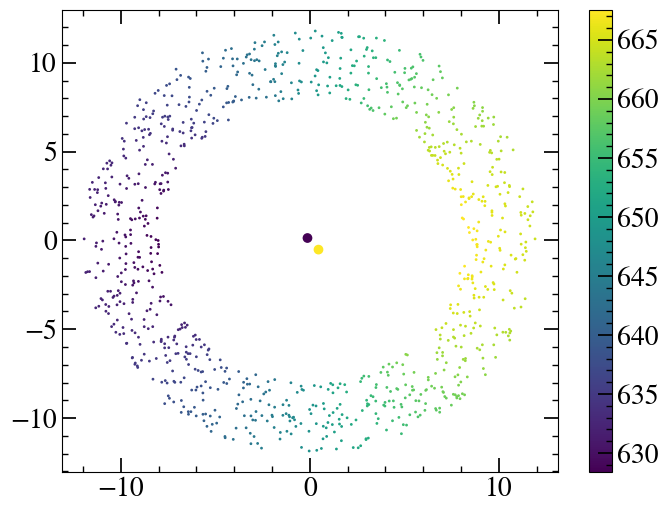

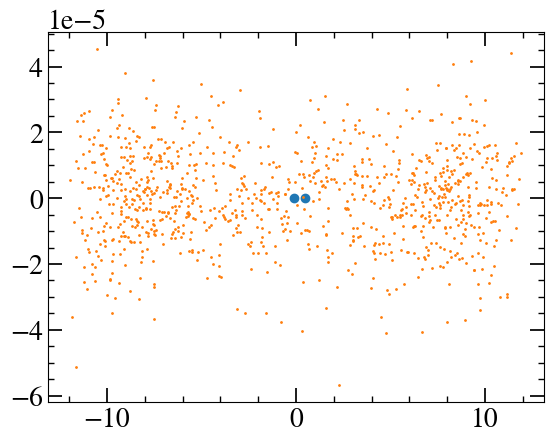

In [18]:
v = smbh_and_binary.velocity
vdisk = disk.velocity

plt.figure(figsize=(8,6))
plt.scatter(smbh_and_binary.x.value_in(units.AU)[1:], smbh_and_binary.y.value_in(units.AU)[1:], c=v.lengths().value_in(units.kms)[1:])
plt.scatter(disk.x.value_in(units.AU), disk.y.value_in(units.AU), s=1, c=vdisk.lengths().value_in(units.kms))
plt.colorbar()

plt.figure()
plt.scatter(smbh_and_binary.x.value_in(units.AU)[1:], smbh_and_binary.z.value_in(units.AU)[1:])
plt.scatter(disk.x.value_in(units.AU), disk.z.value_in(units.AU), s=1)
plt.show() 

In [9]:
print(smbh_and_binary)

                 key         mass         name           vx           vy           vz            x            y            z
                   -         MSun         none       km / s       km / s       km / s           km           km           km
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
12939719945756030232    4.297e+06         SMBH    1.654e-21   -5.325e-04    8.268e-22   -1.115e+06    0.000e+00    0.000e+00
12554127161056033637    2.800e+00      primary   -1.112e+01    6.503e+02   -9.687e+00    1.358e+12   -4.386e+06    1.970e+07
12071077684168610921    7.300e-01    secondary    4.265e+01    6.399e+02    3.716e+01    1.358e+12    1.682e+07   -7.557e+07
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========


In [10]:
from amuse.community.fi.interface import Fi
bodies = smbh_and_binary
binary = smbh_and_binary[1:]

gravity = Huayno(converter)
gravity.set_integrator('OK')
gravity.particles.add_particles(bodies-binary)
channel = {"from stars": bodies.new_channel_to(gravity.particles),
            "to_stars": gravity.particles.new_channel_to(bodies)}

hydro = Fi(converter, mode="openmp")
hydro.parameters.use_hydro_flag = True
hydro.parameters.radiation_flag = False
hydro.parameters.gamma = 1
hydro.parameters.isothermal_flag = True
hydro.parameters.integrate_entropy_flag = False
hydro.parameters.timestep = 0.01*binary_period 
hydro.parameters.verbosity = 0
hydro.parameters.eps_is_h_flag = False  # h_smooth is constant
eps = 0.1 | units.au
hydro.parameters.gas_epsilon = eps
hydro.parameters.sph_h_const = eps

hydro.particles.add_particles(disk)
hydro.dm_particles.add_particles(binary)
channel.update({"from_disk": disk.new_channel_to(hydro.particles)})
channel.update({"to_disk": hydro.particles.new_channel_to(disk)})
channel.update({"from_binary": binary.new_channel_to(hydro.dm_particles)})
channel.update({"to_binary": hydro.dm_particles.new_channel_to(binary)})

bodies.add_particles(disk)

In [11]:
from amuse.couple import bridge
from amuse.ext.composition_methods import *
gravhydro = bridge.Bridge(use_threading=False)  # , method=SPLIT_4TH_S_M4)
gravhydro.add_system(gravity, (hydro,))
gravhydro.add_system(hydro, (gravity,))
gravhydro.timestep = 0.1 * binary_period

In [12]:
from amuse.ext.composition_methods import *
from amuse.ext.orbital_elements import orbital_elements_from_binary

def gravity_hydro_bridge(gravity, hydro, gravhydro, bodies,
                         t_end):

    gravity_initial_total_energy = gravity.get_total_energy() + hydro.get_total_energy()
    model_time = 0 | units.Myr
    dt = 1 | units.yr  # 1.0*Pinner
    while model_time < t_end:

        model_time += dt
        
        dE_gravity = gravity_initial_total_energy / (
            gravity.get_total_energy() + hydro.get_total_energy()
        )
        print("Time:", model_time.in_(units.day), \
              "dE=", dE_gravity)  # , dE_hydro

        gravhydro.evolve_model(model_time)
        channel["to_stars"].copy()
        channel["to_disk"].copy()
        channel["to_binary"].copy()

    gravity.stop()
    hydro.stop()

t_end = 1000 | units.yr
gravity_hydro_bridge(gravity, hydro, gravhydro, 
                     bodies, t_end)

Time: 365.242199 day dE= 1.0
Time: 730.484398 day dE= 1.000003555
Time: 1095.7265970000003 day dE= 1.00000354997
Time: 1460.968796 day dE= 1.00000349936
Time: 1826.2109950000001 day dE= 1.00000355536
Time: 2191.453194 day dE= 1.00000359273
Time: 2556.695393 day dE= 1.00000357672
Time: 2921.937592 day dE= 1.00000364924
Time: 3287.1797910000005 day dE= 1.00000261049
Time: 3652.4219900000007 day dE= 1.00000363994
Time: 4017.664189000001 day dE= 1.00000360408
Time: 4382.906388000001 day dE= 1.0000032113
Time: 4748.1485870000015 day dE= 1.0000036423
Time: 5113.390786000002 day dE= 1.00000366269
Time: 5478.632985000002 day dE= 1.00000365608
Time: 5843.875184000002 day dE= 1.00000368446
Time: 6209.1173830000025 day dE= 1.00000358211
Time: 6574.359582000003 day dE= 1.00000368177
Time: 6939.601781000003 day dE= 1.00000373645
Time: 7304.843980000003 day dE= 1.00000071743
Time: 7670.0861790000035 day dE= 1.00000374844
Time: 8035.328378000004 day dE= 1.00000370115
Time: 8400.570577000004 day dE= 1

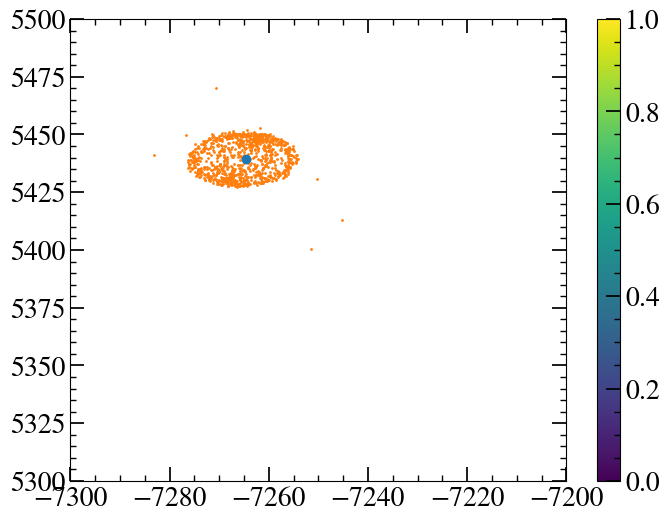

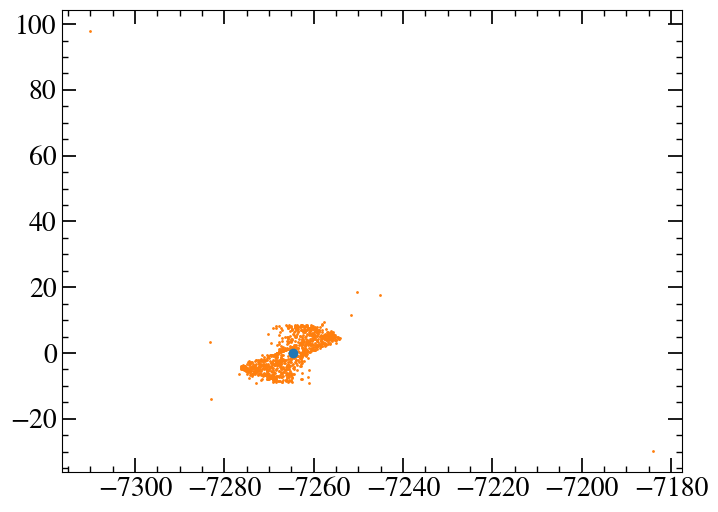

In [24]:
plt.figure(figsize=(8,6))
plt.scatter(smbh_and_binary.x.value_in(units.AU)[1:2], smbh_and_binary.y.value_in(units.AU)[1:2],zorder=100)
plt.scatter(disk.x.value_in(units.AU), disk.y.value_in(units.AU), s=1)
plt.ylim(5300,5500)
plt.xlim(-7300, -7200)
plt.colorbar()
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(smbh_and_binary.x.value_in(units.AU)[1:2], smbh_and_binary.z.value_in(units.AU)[1:2],zorder=100)
plt.scatter(disk.x.value_in(units.AU), disk.z.value_in(units.AU), s=1)
plt.show()

NameError: name 'times' is not defined

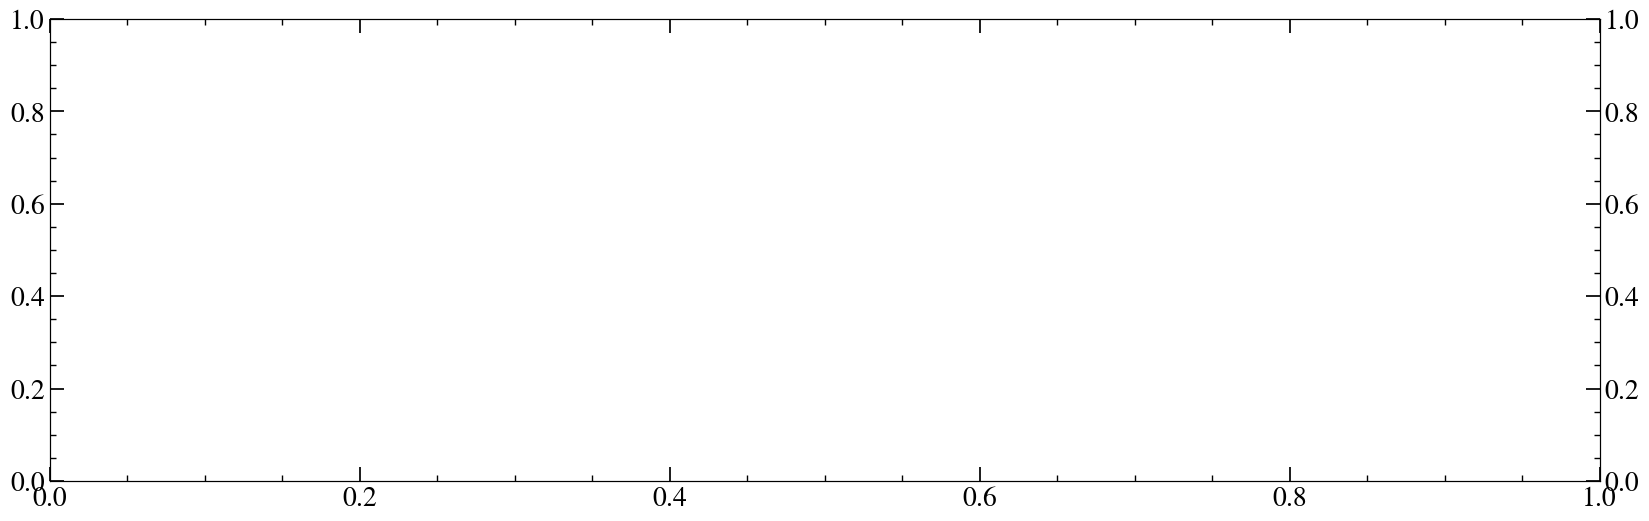

In [13]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax2 = ax1.twinx()

ax1.plot(times.value_in(units.yr), np.array(eccentricities), color='red', label='Eccentricity')
plt.plot(times.value_in(units.yr), inclinations.value_in(units.deg), color='blue', label='Inclination')

ax1.set_xlabel('Time [yr]')
ax1.set_ylabel('Eccentricity', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylim(0,1)

ax2.set_ylabel('Inclination [deg]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(0, 180)

plt.show()

plt.figure(figsize=(8,6))
plt.plot(times.value_in(units.yr), semimajors.value_in(units.AU), color='blue', label='Semimajor axis')
plt.xlabel('Time [Myr]')
plt.legend()
plt.show()

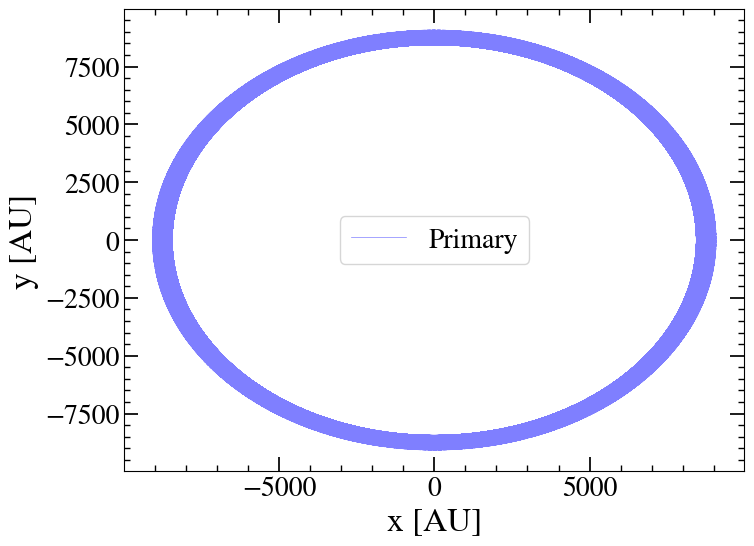

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(pos_primary[:,0].value_in(units.AU)[:5000], pos_primary[:,1].value_in(units.AU)[:5000], color='blue', label='Primary', alpha=0.5, lw=0.5)
# plt.plot(pos_secondary[:,0].value_in(units.AU)[:100], pos_secondary[:,1].value_in(units.AU)[:100], color='red', label='Secondary', alpha=0.5, lw=0.5)
plt.xlabel('x [AU]')
plt.ylabel('y [AU]')
plt.legend()
plt.show()

In [ ]:
# print(binary)
orbital_elements(binary)

(quantity<2.8 MSun>,
 quantity<0.73 MSun>,
 quantity<233430629.735 1000.0 * m>,
 0.5459846861823362,
 quantity<-1.40743968151 rad>,
 quantity<1.80591688849 rad>,
 quantity<-3.04918019081 rad>,
 quantity<-2.49676982052 rad>)

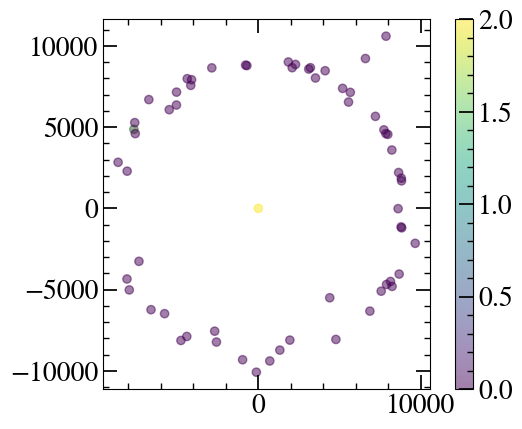

In [ ]:
plt.scatter(smbh_and_binary.x.value_in(units.AU), smbh_and_binary.y.value_in(units.AU), c=smbh_and_binary.mass.value_in(units.Msun), alpha=0.5, vmax = 2, vmin=0)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar()

[  1.50000000e-05   1.00000000e-05   2.00000000e-05]


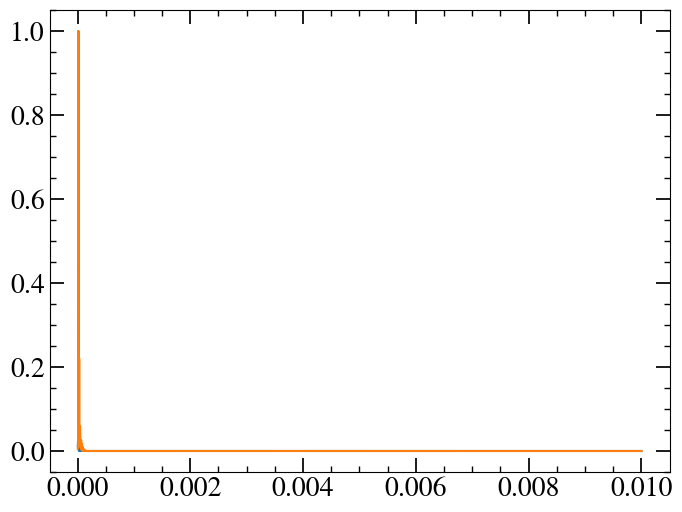

[  1.50000000e-05   3.00000000e-05   4.50000000e-05   2.00000000e-05
   3.50000000e-05   5.00000000e-05   2.50000000e-05   6.50000000e-05
   1.00000000e-05   8.00000000e-05]


In [ ]:
from scipy.signal import periodogram, find_peaks

freq, strength = periodogram(eccentricities, fs=1/stepsize)

plt.figure(figsize=(8,6))
plt.plot(freq[1:], strength[1:] / np.max(strength[1:]))
# plt.xlim(0, 0.05)
# plt.semilogy()

print(freq[list(reversed(np.argsort(strength)))][:3])

freq, strength = periodogram(inclinations.number, fs=1/stepsize)

plt.plot(freq[1:], strength[1:] / np.max(strength[1:]))
# plt.xlim(0, 0.025)
plt.show()

print(freq[list(reversed(np.argsort(strength)))][:10])
